In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os
import shutil
from keras import layers
from keras import losses
from keras.regularizers import L2
from keras import metrics
from sklearn.metrics import confusion_matrix
import tensorflow_probability as tfp
from keras import optimizers

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
os.chdir("/content/drive/My Drive/PCOSGen-train")


In [ ]:
output_folder = r"/content/drive/My Drive/PCOSGen-train/Image Dataset"
healthy = os.path.join(output_folder, "Healthy")
unhealthy = os.path.join(output_folder, "Unhealthy")

os.makedirs(healthy, exist_ok = True)
os.makedirs(unhealthy, exist_ok = True)

In [ ]:
dataset_path = r"/content/drive/My Drive/PCOSGen-train/class_label.xlsx"
df = pd.read_excel(dataset_path)
df.head()

,imagePath,Healthy
0,100image13.jpg,1
1,100image2.jpg,1
2,100image65.jpg,0
3,100image71.jpg,0
4,100image83.jpg,0


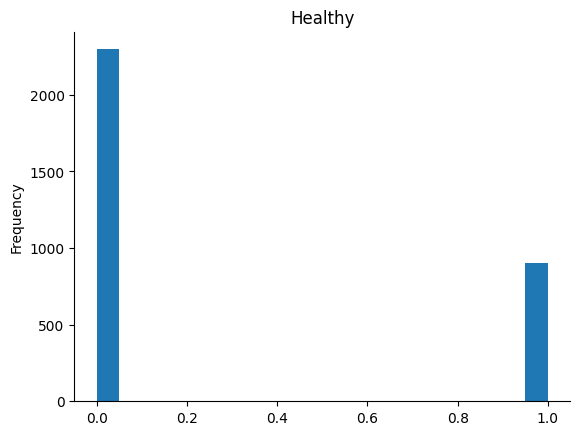

In [ ]:
df['Healthy'].plot(kind='hist', bins=20, title='Healthy')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
for index, row in df.iterrows():
  imgPath = row['imagePath']
  label = row['Healthy']

  source_path = os.path.join(r"/content/drive/My Drive/PCOSGen-train/images",imgPath)

  if (label==1):
    dest_path = os.path.join(healthy, imgPath)
  elif (label==0):
    dest_path = os.path.join(unhealthy, imgPath)

  shutil.copyfile(source_path, dest_path)

In [ ]:
directory_path = r"/content/drive/My Drive/PCOSGen-train/Image Dataset"
CLASS_NAMES = ["Healthy", "Unhealthy"]

In [ ]:
training_dataset, valid_dataset = tf.keras.utils.image_dataset_from_directory(
    directory_path,
    labels = 'inferred',
    label_mode = 'binary',
    color_mode = 'rgb',
    batch_size = 32,
    image_size = (256,256),
    class_names = CLASS_NAMES,
    shuffle = True,
    seed = 42,
    validation_split = 0.2,
    subset = 'both'
)

Found 3200 files belonging to 2 classes.
Using 2560 files for training.
Using 640 files for validation.


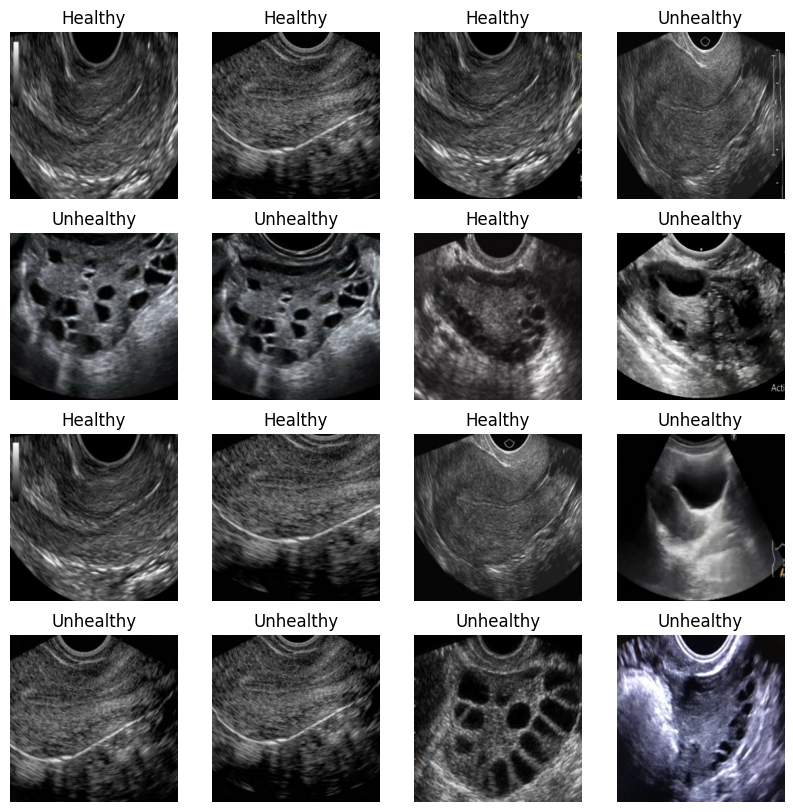

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in training_dataset.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(CLASS_NAMES[labels[i].numpy().astype('uint8')[0]])
    plt.axis("off")
plt.show()

In [ ]:
resize_rescale_layers = tf.keras.Sequential([
    layers.Resizing(256,256),
    layers.Rescaling(1./255)
])

In [ ]:
augment_layers = tf.keras.Sequential([
    layers.RandomRotation(factor = (-0.025,0.025),),
    layers.RandomFlip(mode = 'horizontal',),
    layers.RandomContrast(factor = 0.1),
])

def augment_layer(image, label):
  return augment_layers(image, training = True), label

In [ ]:
training_dataset = (training_dataset.map(augment_layer, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE))
valid_dataset = (valid_dataset.prefetch(tf.data.AUTOTUNE))

In [ ]:
CONFIGURATION = {
    "BATCH_SIZE" : 32,
    "IM_SIZE" : 256,
    "LEARNING_RATE" : 0.001,
    "N_EPOCHS" : 100,
    "DROPOUT_RATE" : 0.0,
    "REGULARIZATION_RATE" : 0.0,
    "N_FILTERS" : 6,
    "KERNEL_SIZE" : 3,
    "N_STRIDES" : 1,
    "POOL_SIZE" : 2,
    "N_DENSE_1" : 1024,
    "N_DENSE_2" : 128,
    "NUM_CLASSES" : 2
}

In [ ]:
lenet_model = tf.keras.Sequential([
    layers.InputLayer(input_shape = (None,None,3)),
    resize_rescale_layers,

    layers.Conv2D(filters = CONFIGURATION['N_FILTERS'], kernel_size = CONFIGURATION['KERNEL_SIZE'], strides = CONFIGURATION['N_STRIDES'], activation = 'relu', kernel_regularizer=L2(CONFIGURATION['REGULARIZATION_RATE'])),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size = CONFIGURATION['POOL_SIZE'], strides = CONFIGURATION['N_STRIDES']*2),
    layers.Dropout(rate = CONFIGURATION['DROPOUT_RATE']),

    layers.Conv2D(filters = CONFIGURATION['N_FILTERS']*2 + 4, kernel_size = CONFIGURATION['KERNEL_SIZE'], strides = CONFIGURATION['N_STRIDES'], activation = 'relu', kernel_regularizer=L2(CONFIGURATION['REGULARIZATION_RATE'])),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size = CONFIGURATION['POOL_SIZE'], strides = CONFIGURATION['N_STRIDES']*2),

    layers.Flatten(),
    layers.Dense(CONFIGURATION['N_DENSE_1'], activation='relu', kernel_regularizer=L2(CONFIGURATION['REGULARIZATION_RATE'])),
    layers.BatchNormalization(),
    layers.Dropout(rate=CONFIGURATION['DROPOUT_RATE']),

    layers.Dense(CONFIGURATION['N_DENSE_2'],activation = 'relu', kernel_regularizer=L2(CONFIGURATION['REGULARIZATION_RATE'])),
    layers.BatchNormalization(),

    layers.Dense(1, activation = 'sigmoid')

])

In [ ]:
lenet_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_5 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 254, 254, 6)       168       
                                                                 
 batch_normalization_6 (Bat  (None, 254, 254, 6)       24        
 chNormalization)                                                
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 127, 127, 6)       0         
 g2D)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 127, 127, 6)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 125, 125, 16)     

In [ ]:
lenet_model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
history = lenet_model.fit(training_dataset, epochs = 50, validation_data = valid_dataset, verbose = 1)

Epoch 1/50
80/80 [==============================] - 34s 366ms/step - loss: 0.6541 - accuracy: 0.6742 - val_loss: 0.6864 - val_accuracy: 0.5594
Epoch 2/50
80/80 [==============================] - 26s 310ms/step - loss: 0.4951 - accuracy: 0.7469 - val_loss: 0.8321 - val_accuracy: 0.4125
Epoch 3/50
80/80 [==============================] - 26s 313ms/step - loss: 0.4722 - accuracy: 0.7527 - val_loss: 1.0031 - val_accuracy: 0.4297
Epoch 4/50
80/80 [==============================] - 25s 304ms/step - loss: 0.4553 - accuracy: 0.7574 - val_loss: 0.7945 - val_accuracy: 0.5719
Epoch 5/50
80/80 [==============================] - 29s 354ms/step - loss: 0.4398 - accuracy: 0.7719 - val_loss: 1.0485 - val_accuracy: 0.4453
Epoch 6/50
80/80 [==============================] - 26s 300ms/step - loss: 0.4470 - accuracy: 0.7750 - val_loss: 0.6609 - val_accuracy: 0.5672
Epoch 7/50
80/80 [==============================] - 27s 331ms/step - loss: 0.4327 - accuracy: 0.7766 - val_loss: 0.6614 - val_accuracy: 0.6000

In [ ]:
lenet_model.evaluate(valid_dataset)

20/20 [==============================] - 2s 114ms/step - loss: 0.7983 - accuracy: 0.7219


[0.7982994914054871, 0.721875011920929]

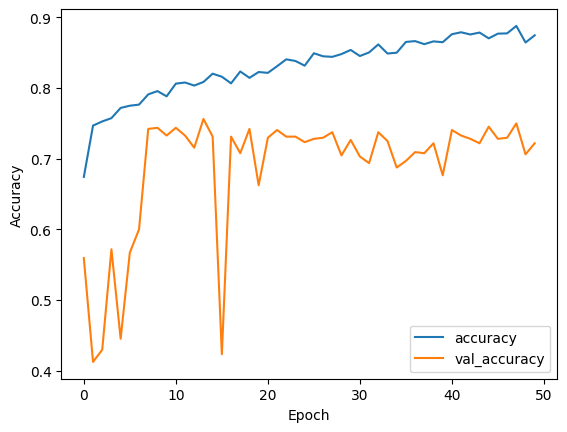

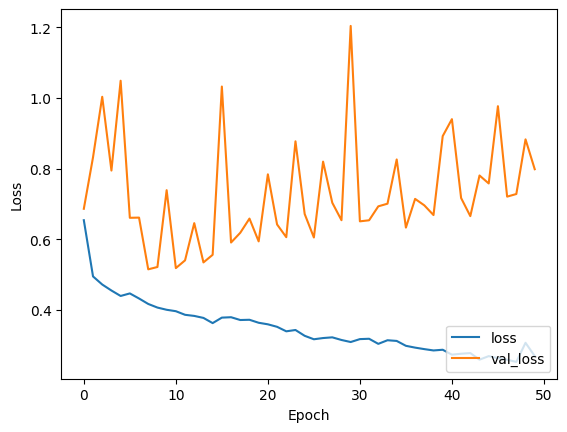

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.show()


1/1 [==============================] - 0s 31ms/step


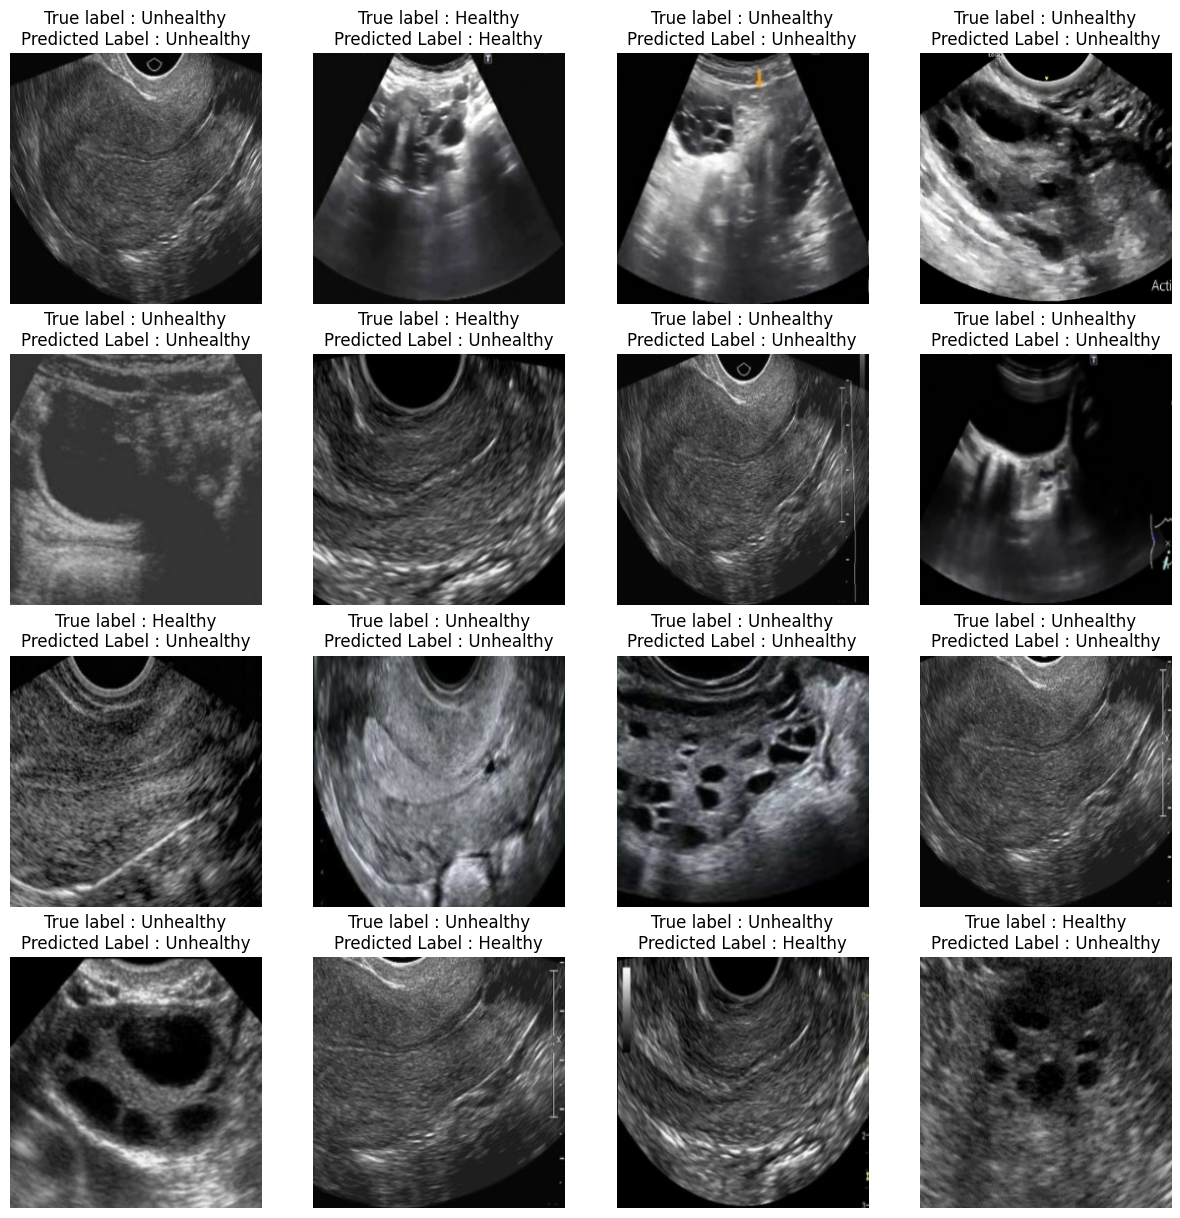

In [ ]:
plt.figure(figsize=(15, 15))

for images, labels in valid_dataset.take(1):
  for i in range(16):
    ax = plt.subplot(4,4, i+1)
    plt.imshow(images[i]/255.)
    predicted_label = lenet_model.predict(tf.expand_dims(images[i], axis = 0))[0][0]
    if (predicted_label >= 0.5):
      predicted_label = 1
    else:
      predicted_label = 0
    plt.title("True label : " + CLASS_NAMES[labels[i].numpy().astype('uint8')[0]] + "\n" + "Predicted Label : " + CLASS_NAMES[predicted_label])

    plt.axis('off')


In [ ]:
def prepareLabels(model, dataset):
  y_true = []
  y_pred = []

  for image,label in dataset:
    for i in range(32):
      y_true.append(label[i].numpy().astype('uint8')[0])

  for image, label in dataset:
    for i in range(32):
      value = model.predict(tf.expand_dims(image[i], axis = 0))[0][0]
      if (value>=0.5):
        y_pred.append(1)
      else:
        y_pred.append(0)
  return y_true, y_pred

1/1 [==============================] - 0s 19ms/step


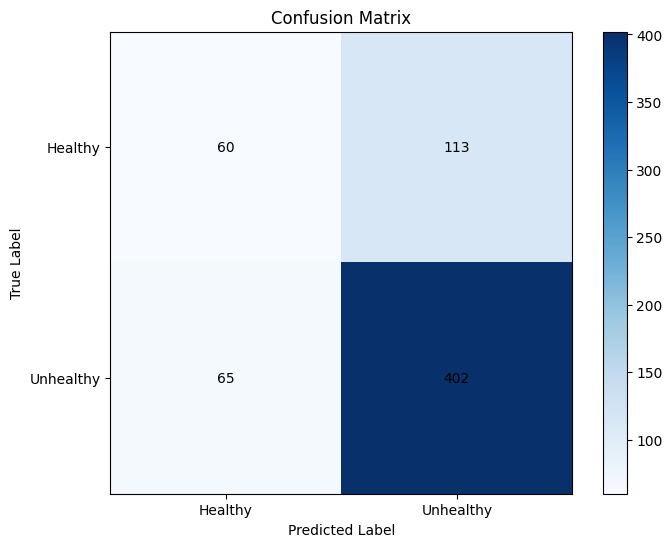

In [ ]:
def printConfusionMatrix(model,dataset):
  y_true,y_pred = prepareLabels(model, dataset)
  cm = confusion_matrix(y_true, y_pred)

  plt.figure(figsize=(8, 6))
  plt.imshow(cm, cmap='Blues')
  plt.colorbar()

  plt.xlabel('Predicted Label')
  plt.ylabel('True Label')
  plt.title('Confusion Matrix')
  plt.xticks(np.arange(len(CLASS_NAMES)), CLASS_NAMES)
  plt.yticks(np.arange(len(CLASS_NAMES)), CLASS_NAMES)

  for i in range(len(CLASS_NAMES)):
    for j in range(len(CLASS_NAMES)):
      plt.text(j, i, cm[i, j], ha='center', va='center', color='black')

  plt.show()

printConfusionMatrix(lenet_model, valid_dataset)

CutMix Data Augmentation

In [ ]:
def box(lamda):
  r_x = tf.cast(tfp.distributions.Uniform(0, 256).sample(1)[0], dtype = tf.int32)
  r_y = tf.cast(tfp.distributions.Uniform(0, 256).sample(1)[0], dtype = tf.int32)

  r_w = tf.cast(256*tf.math.sqrt(1-lamda), dtype = tf.int32)
  r_h = tf.cast(256*tf.math.sqrt(1-lamda), dtype = tf.int32)

  r_x = tf.clip_by_value(r_x - r_w//2, 0, 256)
  r_y = tf.clip_by_value(r_y - r_h//2, 0, 256)

  x_b_r = tf.clip_by_value(r_x + r_w//2, 0, 256)
  y_b_r = tf.clip_by_value(r_y + r_h//2, 0, 256)

  r_w = x_b_r - r_x
  if (r_w==0):
    r_w = 1

  r_h = y_b_r - r_y
  if (r_h==0):
    r_h = 1

  return r_y, r_x, r_h, r_w

In [ ]:
def cutmix(train_dataset_1, train_dataset_2):
  (image_1,label_1), (image_2, label_2) = train_dataset_1, train_dataset_2

  lamda = tfp.distributions.Beta(0.2,0.2)
  lamda = lamda.sample(1)[0]

  r_y, r_x, r_h, r_w = box(lamda)

  crop_2 = tf.image.crop_to_bounding_box(image_2, r_y, r_x, r_h, r_w)
  pad_2 = tf.image.pad_to_bounding_box(crop_2, r_y, r_x, 256, 256)

  crop_1 = tf.image.crop_to_bounding_box(image_1, r_y, r_x, r_h, r_w)
  pad_1 = tf.image.pad_to_bounding_box(crop_1, r_y, r_x, 256, 256)

  image = image_1 - pad_1 + pad_2

  lamda = tf.cast(1 - (r_w*r_h)/(256**2), dtype = tf.float32)
  label = lamda*tf.cast(label_1, dtype = tf.float32) + (1-lamda)*tf.cast(label_2, dtype = tf.float32)

  return image,label

In [ ]:
train_dataset_1 = training_dataset.map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE)
train_dataset_2 = training_dataset.map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE)

mixed_dataset = tf.data.Dataset.zip((train_dataset_1, train_dataset_2))

In [ ]:
training_dataset_cutmix = (mixed_dataset.map(cutmix, num_parallel_calls = tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE))

In [ ]:
training_dataset_cutmix

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>

In [ ]:
valid_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>

In [ ]:
history_cutmix = lenet_model.fit(training_dataset_cutmix, epochs = 50, validation_data = valid_dataset, verbose = 1)

Epoch 1/50
80/80 [==============================] - 77s 893ms/step - loss: 0.4337 - accuracy: 0.5289 - val_loss: 0.7069 - val_accuracy: 0.6734
Epoch 2/50
80/80 [==============================] - 78s 915ms/step - loss: 0.4411 - accuracy: 0.5258 - val_loss: 1.3800 - val_accuracy: 0.7391
Epoch 3/50
80/80 [==============================] - 80s 949ms/step - loss: 0.4126 - accuracy: 0.5434 - val_loss: 0.5899 - val_accuracy: 0.7344
Epoch 4/50
80/80 [==============================] - 76s 902ms/step - loss: 0.4212 - accuracy: 0.5398 - val_loss: 0.6582 - val_accuracy: 0.7391
Epoch 5/50
80/80 [==============================] - 80s 923ms/step - loss: 0.4047 - accuracy: 0.5262 - val_loss: 0.6313 - val_accuracy: 0.7344
Epoch 6/50
80/80 [==============================] - 81s 953ms/step - loss: 0.4054 - accuracy: 0.5262 - val_loss: 0.6968 - val_accuracy: 0.7156
Epoch 7/50
80/80 [==============================] - 78s 906ms/step - loss: 0.4221 - accuracy: 0.5223 - val_loss: 0.7430 - val_accuracy: 0.7344

In [ ]:
lenet_model.evaluate(valid_dataset)

In [ ]:
plt.plot(history_cutmix.history['accuracy'], label='accuracy')
plt.plot(history_cutmix.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

plt.plot(history_cutmix.history['loss'], label='loss')
plt.plot(history_cutmix.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.show()


In [ ]:
plt.figure(figsize=(15, 15))

for images, labels in valid_dataset.take(1):
  for i in range(16):
    ax = plt.subplot(4,4, i+1)
    plt.imshow(images[i]/255.)
    predicted_label = lenet_model.predict(tf.expand_dims(images[i], axis = 0))[0][0]
    if (predicted_label >= 0.5):
      predicted_label = 1
    else:
      predicted_label = 0
    plt.title("True label : " + CLASS_NAMES[labels[i].numpy().astype('uint8')[0]] + "\n" + "Predicted Label : " + CLASS_NAMES[predicted_label])

    plt.axis('off')


In [ ]:
printConfusionMatrix(lenet_model, valid_dataset)

Transfer Learning with EfficientNet

In [ ]:
backbone = tf.keras.applications.efficientnet.EfficientNetB4(
    include_top = False,
    weights = 'imagenet',
    input_shape = (256, 256, 3),
)

In [ ]:
backbone.trainable = False

In [ ]:
CONFIGURATION["N_DENSE_1"]

In [ ]:
model = tf.keras.Sequential([
    layers.Input(shape = (256, 256, 3)),
    backbone,
    layers.GlobalAveragePooling2D(),
    layers.Dense(CONFIGURATION["N_DENSE_1"], activation = 'relu'),
    layers.BatchNormalization(),
    layers.Dense(CONFIGURATION["N_DENSE_2"], activation = 'relu'),
    layers.Dense(1, activation = 'sigmoid')
])

In [ ]:
model.summary()

In [ ]:
model.compile(optimizer = optimizers.Adam(learning_rate = CONFIGURATION['LEARNING_RATE']), loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
history = model.fit(training_dataset, validation_data = valid_dataset, epochs = 50, verbose = 1)

In [ ]:
model.evaluate(valid_dataset)

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.show()

In [ ]:
plt.figure(figsize=(15, 15))

for images, labels in valid_dataset.take(1):
  for i in range(16):
    ax = plt.subplot(4,4, i+1)
    plt.imshow(images[i]/255.)
    predicted_label = model.predict(tf.expand_dims(images[i], axis = 0))[0][0]
    if (predicted_label >= 0.5):
      predicted_label = 1
    else:
      predicted_label = 0
    plt.title("True label : " + CLASS_NAMES[labels[i].numpy().astype('uint8')[0]] + "\n" + "Predicted Label : " + CLASS_NAMES[predicted_label])

    plt.axis('off')

In [ ]:
printConfusionMatrix(model, valid_dataset)